*Projek Klasifikasi Sampah*

In [33]:
import numpy as np
import pandas as pd

import os
import shutil
from shutil import copyfile

from PIL import Image
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import keras
from keras.applications import ResNet50
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
# import tensorflowjs as tfjs
from tensorflow.keras.models import load_model
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau



from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image

In [34]:
os.listdir('./')

['.ipynb_checkpoints', 'notebook.ipynb', 'Sampah-Dataset']

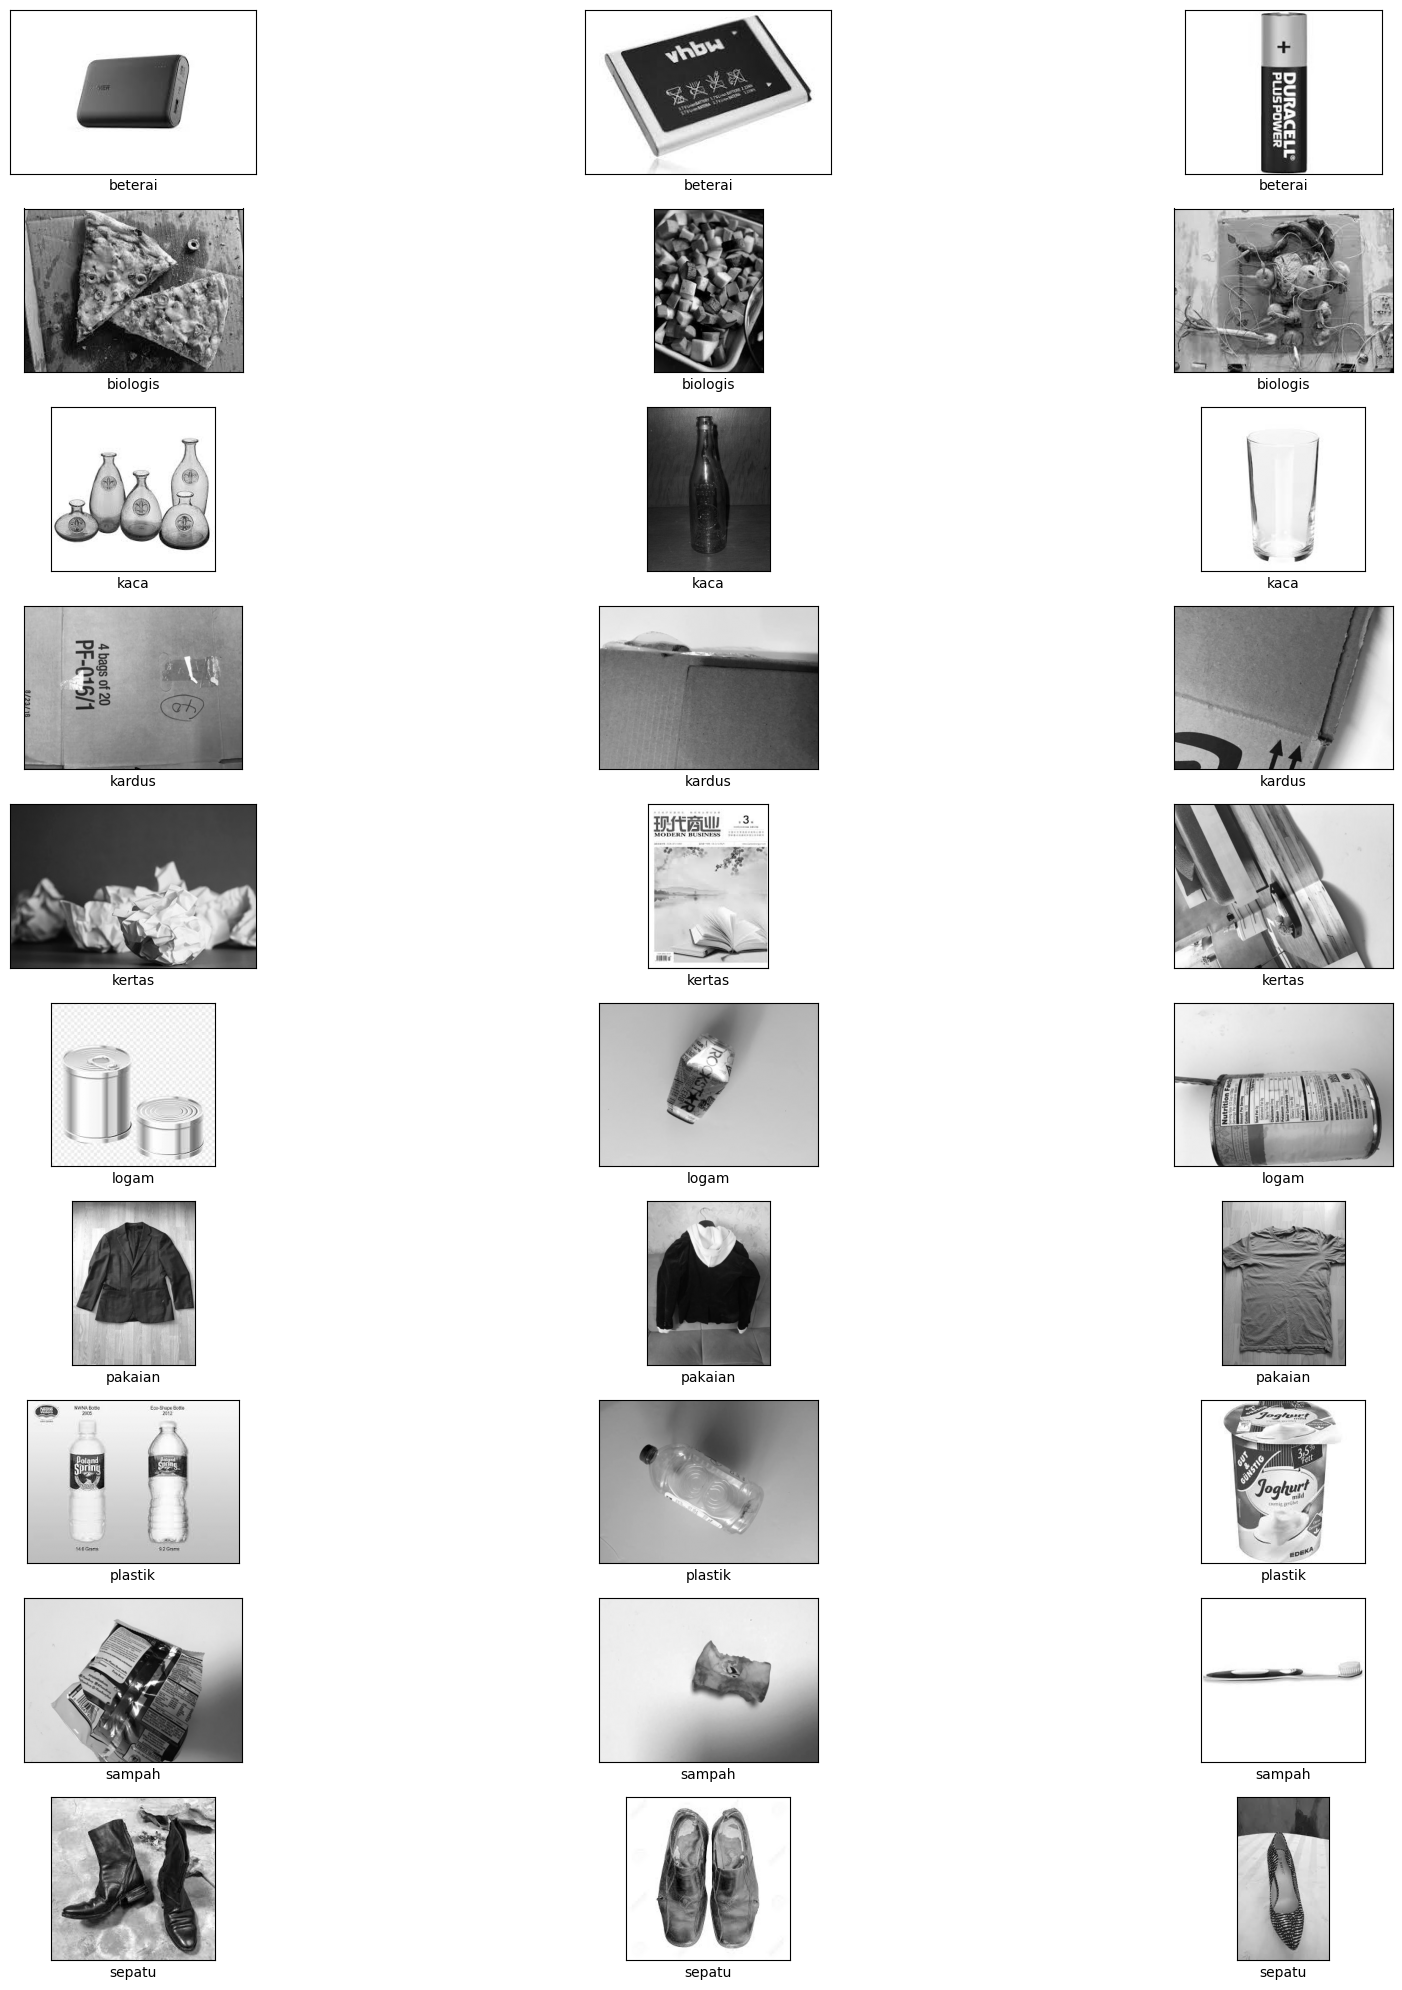

In [35]:
imgs = {}

path = "./Sampah-DataSet"
path_sub = os.path.join(path, "dataset")
for i in os.listdir(path_sub):
    imgs[i] = os.listdir(os.path.join(path_sub, i))

fig, axs = plt.subplots(len(imgs.keys()), 3, figsize=(20, 20))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(imgs[class_name], 3, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path).convert("L") 
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

In [36]:
def print_images_resolustion(directory):
    unique_sizes = set()
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)

        if os.path.isdir(subdir_path):
            image_files = os.listdir(subdir_path)
            num_images = len(image_files)
            print(f"{subdir} : {num_images} images")
            total_images += num_images

            for img_file in image_files:
                img_path = os.path.join(subdir_path, img_file)
                try:
                    with Image.open(img_path) as img:
                        unique_sizes.add(img.size)
                except Exception as e:
                    print(f"Error opening image : {img_path} : {e}")
        
    print("\nUnique Image Size: ")
    for size in unique_sizes:
        print(f"- {size}")

    print("-----------")
    print(f"\nTotal Images across all subdirectsories: {total_images}")

directory = "./Sampah-Dataset/dataset"
print_images_resolustion(directory)

beterai : 945 images
biologis : 985 images
kaca : 3061 images
kardus : 891 images
kertas : 2730 images
logam : 1789 images
pakaian : 5325 images
plastik : 865 images
sampah : 1644 images
sepatu : 1977 images

Unique Image Size: 
- (306, 304)
- (277, 277)
- (1200, 1600)
- (150, 322)
- (276, 318)
- (630, 401)
- (315, 160)
- (400, 613)
- (600, 787)
- (452, 394)
- (154, 328)
- (400, 469)
- (382, 600)
- (900, 1200)
- (334, 151)
- (200, 300)
- (280, 180)
- (320, 216)
- (69, 225)
- (257, 196)
- (141, 250)
- (1588, 1987)
- (209, 241)
- (600, 800)
- (685, 1024)
- (2160, 2149)
- (800, 416)
- (298, 169)
- (289, 349)
- (400, 711)
- (475, 247)
- (400, 482)
- (352, 405)
- (248, 204)
- (428, 400)
- (474, 287)
- (231, 300)
- (250, 250)
- (405, 273)
- (264, 297)
- (350, 337)
- (2000, 1500)
- (662, 752)
- (200, 169)
- (1500, 1442)
- (570, 605)
- (800, 1067)
- (201, 250)
- (221, 228)
- (474, 408)
- (400, 459)
- (186, 270)
- (1200, 628)
- (674, 698)
- (248, 181)
- (220, 119)
- (230, 169)
- (409, 400)
- (2

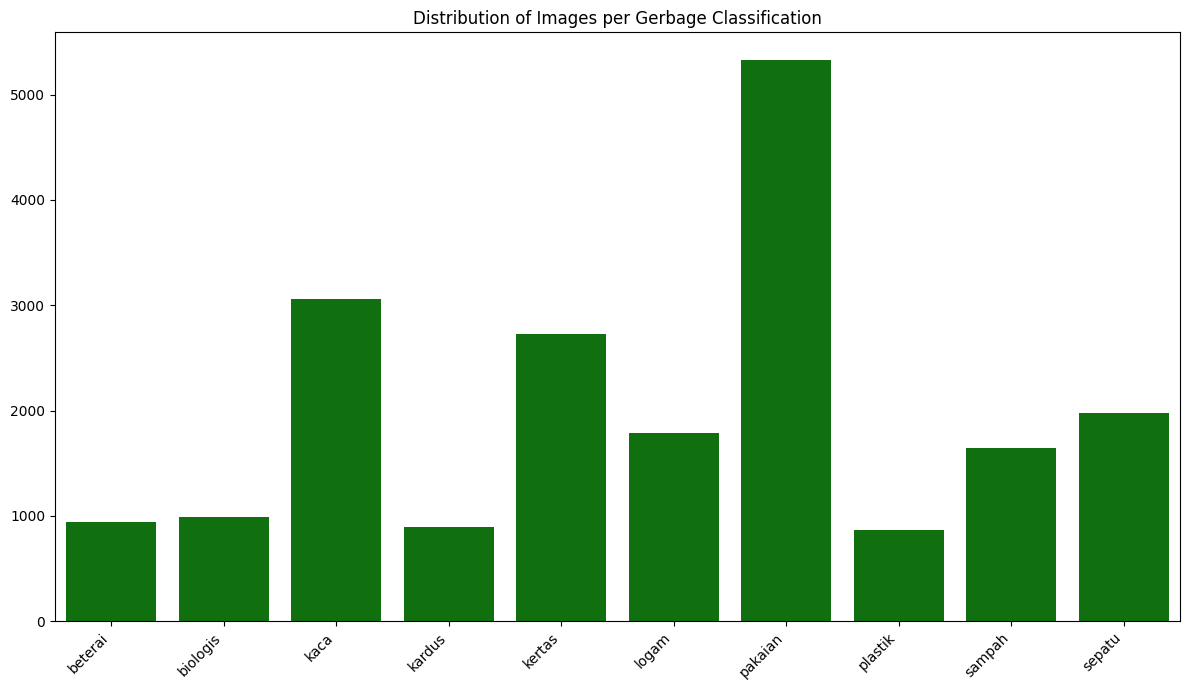

In [37]:
path = './Sampah-Dataset/dataset'

file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(path):
    for name in files:
        full_path.append(os.path.join(path,name))
        labels.append(path.split('/dataset\\')[-1])
        file_name.append(name)

df = pd.DataFrame({
    "path" : full_path, 
    'file_name' : file_name,
    'labels' : labels 
})

label_counts = df.groupby('labels').size().reset_index(name = 'count')

plt.figure(figsize = (12, 7))
ax = sns.barplot(x = 'labels', y = 'count', data=label_counts, color = 'green')

plt.xticks(rotation = 45, ha = 'right')

plt.xlabel(None)
plt.ylabel(None)
plt.title('Distribution of Images per Gerbage Classification')

plt.tight_layout()
plt.show()

*PREPROCESSING*

In [38]:
TRAIN_DIR = "./Sampah-Dataset/dataset"

image_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    validation_split = 0.2
)

validation_datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2
)

train_generator = image_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size = (100,100),
    batch_size = 64,
    class_mode = 'categorical',
    subset = 'training'
) 

validation_generator = validation_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size = (100,100),
    batch_size = 64,
    class_mode = 'categorical',
    subset = 'validation'
)


test_datagen = ImageDataGenerator(
    rescale=1./255
)

TRAIN_DIR_TEST = "./Sampah-Dataset/dataset-test"

test_generator = test_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size = (100,100),
    batch_size = 64,
    class_mode = 'categorical',
) 



Found 16172 images belonging to 10 classes.
Found 4040 images belonging to 10 classes.
Found 20212 images belonging to 10 classes.


*MODELLING*

In [39]:
model = Sequential()

model.add(Conv2D(32, (3,3), padding='same',activation='relu', input_shape = (100, 100, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(32, (4,4), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(32, (7,7), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(13, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(),loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 50, 50, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 50, 50, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 25, 25, 32)     │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 25, 25, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 6, 6, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 6, 6, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 13)             │           845 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,797 (807.80 KB)

 Trainable params: 206,349 (806.05 KB)

 Non-trainable params: 448 (1.75 KB)

None


In [ ]:
class EarlyStopping(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
        if logs.get('val_accuracy') >= 0.87:
            print(f"\n# This callback stop the training at : \nEpoch : {epoch} Val_acuuracy : %{logs['val_accuracy']*100}")

history = model.fit(
    train_generator,              
    steps_per_epoch=len(train_generator),   
    validation_data=validation_generator,  
    validation_steps=10,   
    epochs=50,  
    verbose=1  
)

model.save("model_klasifikasi_sampah.h5")

Epoch 1/50


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 10), output.shape=(None, 13)